# Objective
Demonstrate recover of HR from BART Model

In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt

In [2]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/simsurv_func.py'>

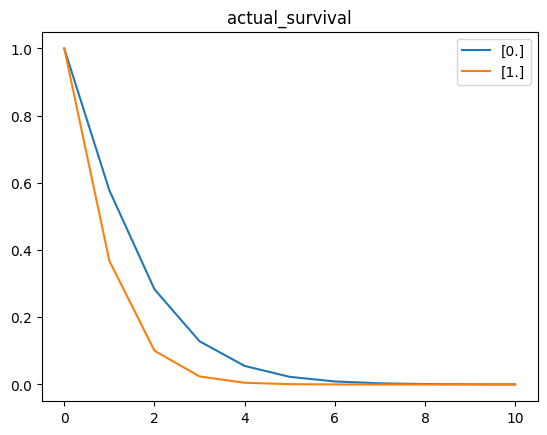

cens_calc: 0.0     
t_mean: 1.77     
t_max: 10.0
hazard rate 1 [1.49488 1.71716 1.86221]
hazard rate 0 [0.82041 0.9424  1.02201]
HR t-series = [1.82211333 1.82211375 1.82210546]


/tmp/ipykernel_3317/2872186124.py:40: RuntimeWarning: invalid value encountered in divide
  HR_unique = hz_unique[1]/hz_unique[0]


In [87]:
OUTPUTS = "outputs"
ALPHA = 1.2
LAMBDA = "np.exp(-.5 +.5*x_mat[:,0])"
N = 100
# T = 30
X_VARS = 1
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                a = ALPHA,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# get unique x_mat
x_unique = np.unique(x_mat, return_index=True)
sv_unique = sv_mat[x_unique[1],:]
hz_unique = np.round(hz_mat[x_unique[1],:],5) 

HR_unique = hz_unique[1]/hz_unique[0]
# HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
HR_times = np.array((np.ceil(T.shape[0]/4) * np.array([1,2,3])), dtype="int")
print(f"hazard rate 1 {hz_unique[1][HR_times]}")
print(f"hazard rate 0 {hz_unique[0][HR_times]}")
print(f"HR t-series = {HR_unique[HR_times]}")

Hazard rate is calculated along with the survival.
The Hazard Ratio can be calculated from the hazard rates

The HR for a variable is exp(B) or calculated as the Hazard Rate[1]/Hazard Rate[0] where 1 and 0 are the values variable from X.

In [88]:
# BART
M = 200 # number of trees
DRAWS = 200
TUNE = 200
CORES = 4

y_sk = ssf.get_y_sklearn(status, t_event)
x_sk = train.iloc[:,2:]


# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk)
# b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))
# model bart

Only 200 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 27 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


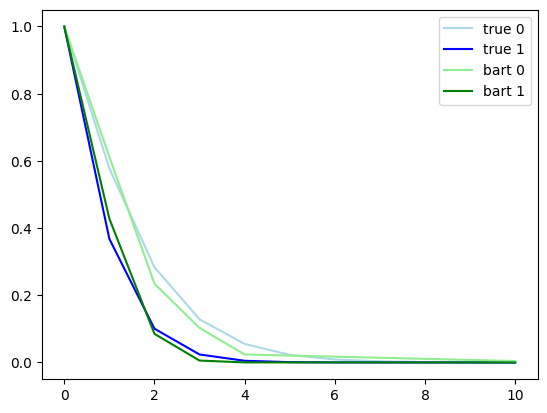

In [89]:
with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = [pmb.ContinuousSplitRule(), pmb.OneHotSplitRule()])
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=200, tune = 200, cores=4)

with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])

# transform to survival
bart_sv_fx = ssf.get_sv_fx(pp, x_out)
# bart_svt
bart_sv_t = np.unique(b_tr_t)

# add a time 0 with prob 1 
bart_sv_t = np.concatenate([np.array([0]), bart_sv_t])
bart_sv_val = [np.concatenate([np.array([1]), sv]) for sv in bart_sv_fx]


plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
plt.plot(T, sv_unique[1], color = "blue", label="true 1")
plt.plot(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 0")
plt.plot(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1")
plt.legend()

In [90]:
pp_shape = pp.posterior_predictive.mu.values.shape

mu = pp.posterior_predictive.mu.values.reshape(pp_shape[0]*pp_shape[1], pp_shape[2]).mean(0).reshape(2,int(pp_shape[2]/2))


print(f"pred hz 1 \n {mu[1]}")
print(f"pred hz 0 \n {mu[0]}")
print(f"hazard ratio all: \n {(mu[1]/mu[0]).mean()}")
print(f"hazard ratio all: \n {(mu[1].mean()/mu[0].mean())}")
hrt = 1
hrt2 = 1
print(f"mean hazard ratio in key timepoines: \n {(mu[1][hrt:-hrt2]/mu[0][hrt:-hrt2]).mean()}")
print(f"hazard ratio in key timepoines: \n {(mu[1][hrt:-hrt2]/mu[0][hrt:-hrt2])}")

print(f"hazard rate 1 \n {hz_unique[1][hrt:-hrt2]}")
print(f"hazard rate 0 \n {hz_unique[0][hrt:-hrt2]}")
print(f"HR t-series = \n {HR_unique[hrt:-hrt2]}")

pred hz 1 
 [0.57196232 0.80089511 0.93277524 0.96421822 0.97375359]
pred hz 0 
 [0.3880675  0.61666483 0.56112319 0.76851209 0.82006699]
hazard ratio all: 
 1.3754050284731183
hazard ratio all: 
 1.3452821186945574
mean hazard ratio in key timepoines: 
 1.4052481661650795
hazard ratio in key timepoines: 
 [1.29875269 1.66233593 1.25465588]
hazard rate 1 
 [1.2     1.37844 1.49488 1.58341 1.65568 1.71716 1.77093 1.81886 1.86221]
hazard rate 0 
 [0.65857 0.7565  0.82041 0.86899 0.90865 0.9424  0.97191 0.99821 1.02201]
HR t-series = 
 [1.82212977 1.82212822 1.82211333 1.82212684 1.82213173 1.82211375
 1.82211316 1.8221216  1.82210546]


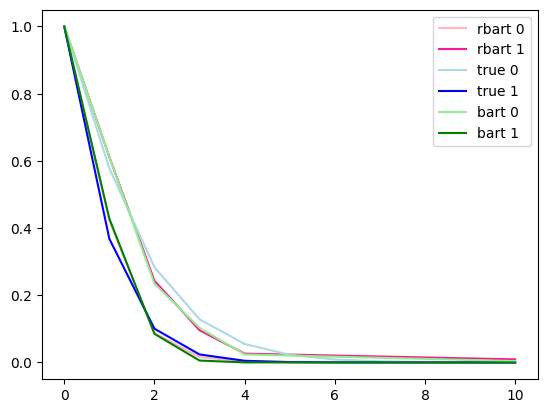

In [118]:
tmp = pd.read_csv("eval_4_tmp.csv")
sv1 = tmp["x"][0:5]
sv2 = tmp["x"][5:]

plt.plot(bart_sv_t, np.concatenate([[1],sv1]), color = "lightpink", label = "rbart 0")
plt.plot(bart_sv_t, np.concatenate([[1],sv2]), color="deeppink", label= "rbart 1")
plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
plt.plot(T, sv_unique[1], color = "blue", label="true 1")
plt.plot(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 0")
plt.plot(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1")
plt.legend()

In [98]:
train.to_csv("eval_4.csv")

In [95]:
# (1-hz_unique[0]).cumprod()

hz_val0 = mu[0]/bart_sv_val[0][1:]
hz_val1 = mu[1]/bart_sv_val[1][1:]

hz_val0
hz_val1
train
T
# np.round(hz_val,0)
# (hz_val1/hz_val0).mean()
# (1- mu[0]).cumprod()
# np.unique(b_tr_t).shape
# plt.plot(np.arange(0,4,1), hz_val[0:4])
# plt.plot(np.arange(0,4,1), hz_unique[0][1:5])
# plt.plot(np.arange(0,hz_val.shape[0],1), hz_unique[0][1:-1])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

<lifelines.CoxPHFitter: fitted with 100 total observations, 0 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 100
number of events observed = 100
   partial log-likelihood = -360.41
         time fit was run = 2023-09-07 19:27:51 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
X0          0.54       1.72       0.21             0.13             0.96                 1.13                 2.62

            cmp to    z    p   -log2(p)
covariate                              
X0            0.00 2.55 0.01       6.55
---
Concordance = 0.59
Partial AIC = 722.81
log-likelihood ratio test = 6.66 on 1 df
-log2(p) of ll-ratio test = 6.67

Text(8.0, 0.4, 'True Ave HR 1.82')

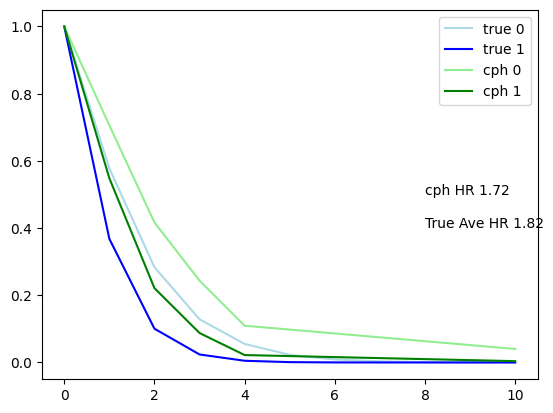

In [96]:
# lifelines
cphl = lifelines.CoxPHFitter()
cphl.fit(train, duration_col="time", event_col="status")
cphl.print_summary()
cphl_pred = cphl.predict_survival_function(pd.DataFrame(x_out, columns= ["X0"]))
cphl_pred.columns=["a", "b"]
cdhl_pred = pd.concat([pd.DataFrame([[1,1]], columns = ["a","b"]),cphl_pred], axis=0)

# plot
# plt.plot(np.arange(0,T,1), sv_unique[0], color= "lightblue", label="true 0")
# plt.plot(np.arange(0,T,1), sv_unique[1], color = "blue", label="true 1")
plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
plt.plot(T, sv_unique[1], color = "blue", label="true 1")

plt.plot(cdhl_pred.index, cdhl_pred["a"], label = "cph 0", color="lightgreen")
plt.plot(cdhl_pred.index, cdhl_pred["b"], label = "cph 1", color = "green")

plt.legend()

# get cphl HR
cphl_expco = cphl.summary["exp(coef)"]
# plt.text(T-T/5,.5,f"cph HR {np.round(cphl_expco[0],2)}")
plt.text(T.max()-T.max()/5,.5,f"cph HR {np.round(cphl_expco[0],2)}")


# get TRUE HR
hz_unique = hz_mat[x_unique[1],:]
true_HR = np.round(hz_unique[1].mean()/hz_unique[0].mean(),2)
# plt.text(T-T/5,.4, f"True Ave HR {true_HR}")
plt.text(T.max()-T.max()/5,.4, f"True Ave HR {true_HR}")

# Concordance 

In [121]:
# bart_sv_val
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [139]:
(1-pp.posterior_predictive.mu).cumprod("mu_dim_2")
pp.posterior_predictive.mu.squeeze("mu_dim_2")

ValueError: cannot select a dimension to squeeze out which has length greater than one

In [142]:
import xarray as xr

In [144]:
c, t = [arr.flatten() for arr in np.meshgrid(range(10), range(1234, 1234+10))]

da = xr.DataArray( 
    np.random.randn(100, 3), 
    dims=('ct', 'x'), 
    coords={ 
        'c': ('ct', c), 
        't': ('ct', t) 
    }
)
da

<xarray.DataArray (ct: 100, x: 3)>
array([[-0.07212276, -0.76133257, -0.85921811],
       [ 1.25528196,  0.82408246, -0.42962408],
       [ 0.17753579, -0.96683064, -0.7992792 ],
       [-1.26568307, -0.79049   ,  0.89310324],
       [-0.87960009,  0.6796221 , -0.11067839],
       [-0.94682218, -0.31720585, -0.60098143],
       [-1.18899764,  0.06684109,  2.48711639],
       [-1.63511346,  0.55005232, -0.19305565],
       [-1.57684879, -1.09268964,  0.02514318],
       [ 1.24319748, -0.20009977, -0.06080033],
       [ 0.50589013, -0.82535393, -0.36898551],
       [-0.43700841, -0.61185737,  0.45380575],
       [-1.384799  ,  0.31650463, -0.09725835],
       [-1.74021186, -0.14079569,  0.1261463 ],
       [ 0.92426388, -0.62063933, -0.25714324],
       [-0.02808724,  0.86643625, -1.4737634 ],
       [ 0.24512635,  2.26309066, -0.59670931],
       [-1.32575656, -1.56647621,  0.73615521],
       [ 0.76589794,  2.03256587,  0.43370238],
       [ 1.15619177, -0.44194164, -1.46207474],
...
       [-0.58724006, -0.75487721, -2.08216635],
       [-0.66891344, -0.38938406,  0.96445436],
       [-1.52802521, -0.19450788,  0.67623137],
       [-1.25069721, -1.22628154, -1.43372117],
       [-1.26164541, -0.07098026,  0.91283196],
       [-0.55918847,  1.99084409, -0.04160479],
       [ 0.18676327,  0.40497942, -2.43994465],
       [-0.40189067, -0.72152161, -0.65179844],
       [ 0.03528738,  0.13881903, -1.04777645],
       [-0.47204826,  0.49537645, -0.73859595],
       [ 0.99015587, -0.706813  ,  0.88592621],
       [ 0.57200402,  0.49861742, -0.71756482],
       [-0.11213922,  0.57111215, -1.04022689],
       [ 0.47857954, -0.69435792,  0.07241719],
       [ 0.83766692,  0.28834193,  0.38046887],
       [-0.83739779, -0.36044231, -0.85757755],
       [-1.23559995,  0.30261794,  0.12804735],
       [ 1.0121386 , -0.59424587,  1.28392964],
       [-0.69652047,  0.60174937,  0.8471617 ],
       [-0.04878195, -0.07755299,  0.44973474]])
Coordinates:
    c        (ct) int64 0 1 2 3 4 5 6 7 8 9 0 1 2 ... 7 8 9 0 1 2 3 4 5 6 7 8 9
    t        (ct) int64 1234 1234 1234 1234 1234 ... 1243 1243 1243 1243 1243
Dimensions without coordinates: ct, x

In [150]:
data = np.random.rand(4, 3)

np.repeat(np.arange(1,10,1),2)
locs = ["IA", "IL", "IN"]

times = pd.date_range("2000-01-01", periods=4)

foo = xr.DataArray(data, coords=[times, locs], dims=["time", "space"])

print(foo)
foo.mean("space")

<xarray.DataArray (time: 4, space: 3)>
array([[0.45286422, 0.29095781, 0.84559007],
       [0.5028633 , 0.18993322, 0.94443725],
       [0.87357586, 0.1801326 , 0.9808894 ],
       [0.47377437, 0.51775815, 0.03285349]])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04
  * space    (space) <U2 'IA' 'IL' 'IN'


<xarray.DataArray (time: 4)>
array([0.52980403, 0.54574459, 0.67819928, 0.34146201])
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 2000-01-04

In [172]:
n = np.tile(np.arange(0,10,1),(3,2)).T
n[:,1] = n[:,1] + 1
n[:,2] = n[:,2] + 2
cols = ["a", "b", "c"]
rows = np.repeat([1,2],10)

df = xr.Dataset(
    {"n": (["rows", "cols"], n)},
    coords = {"cols": cols, "rows":rows}
    # dims = ["rows", "cols"]
)
df

<xarray.Dataset>
Dimensions:  (rows: 20, cols: 3)
Coordinates:
  * cols     (cols) <U1 'a' 'b' 'c'
  * rows     (rows) int64 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
Data variables:
    n        (rows, cols) int64 0 1 2 1 2 3 2 3 4 3 4 ... 8 7 8 9 8 9 10 9 10 11

In [180]:
temp = 15 + 8 * np.random.randn(2, 2, 3)

precip = 10 * np.random.rand(2, 2, 3)

lon = [[-99.83, -99.32], [-99.79, -99.23]]

lat = [[42.25, 42.21], [42.63, 42.59]]

ds = xr.Dataset(
    {
        "temperature": (["x", "y", "time"], temp),
        "precipitation": (["x", "y", "time"], precip),
    },
    coords={
        "lon": (["x", "y"], lon),
        "lat": (["x", "y"], lat),
        "time": pd.date_range("2014-09-06", periods=3),
        "reference_time": pd.Timestamp("2014-09-05"),
    },
)
ds.indexes

Indexes:
    time     DatetimeIndex(['2014-09-06', '2014-09-07', '2014-09-08'], dtype='datetime64[ns]', name='time', freq='D')

In [190]:
midx = pd.MultiIndex.from_arrays(
    [["R", "R", "V", "V"], [0.1, 0.2, 0.7, 0.9]], names=("band", "wn")
)
# print(midx)
midx

mda = xr.DataArray(np.random.rand(4), coords={"spec": midx}, dims="spec")

mda["spec"]

<xarray.DataArray 'spec' (spec: 4)>
array([('R', 0.1), ('R', 0.2), ('V', 0.7), ('V', 0.9)], dtype=object)
Coordinates:
  * spec     (spec) object MultiIndex
  * band     (spec) object 'R' 'R' 'V' 'V'
  * wn       (spec) float64 0.1 0.2 0.7 0.9

In [184]:
pp.posterior_predictive.indexes

Indexes:
    chain         Index([0, 1, 2, 3], dtype='int64', name='chain')
    draw          Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199],
      dtype='int64', name='draw', length=200)
    y_pred_dim_2  Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='y_pred_dim_2')
    f_dim_2       Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='f_dim_2')
    z_dim_2       Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='z_dim_2')
    mu_dim_2      Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='mu_dim_2')

In [119]:
S1 = bart_sv_val[1]
S2 = bart_sv_val[0]
q1 = 1-mu[1]
q2 = 1-mu[0]

c = np.zeros(q1.shape[0])
for i,idx in enumerate(np.arange(0,q1.shape[0],1)):
    if i == 0:
        c[i] = q1[i] - q2[i]
    else:
        c[i] = (q1[i] - q2[i]) * S1[i-1] * S2[i-1]

0.5 * (1-c.sum())


0.7347375458241542